In [ ]:
# Pusula Academy Data Science Case Study
# Name and Surname: Sema Altınışık
# Mail: altnsksema@gmail.com

In [26]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
#DATA DEFINITION AND EDA ANALYZING PHASE

In [27]:
# Önce verimizi okuyalım.
df = pd.read_excel("/content/Talent_Academy_Case_DT_2025.xlsx")

In [28]:
# Sütunlarımızı öğrenelim buna bakarak işlem yapacağız çünkü.
print(df.columns)

Index(['HastaNo', 'Yas', 'Cinsiyet', 'KanGrubu', 'Uyruk', 'KronikHastalik',
       'Bolum', 'Alerji', 'Tanilar', 'TedaviAdi', 'TedaviSuresi',
       'UygulamaYerleri', 'UygulamaSuresi'],
      dtype='object')


In [29]:
# Null sayısını öğreniyoruz en fazla Alerji sütununda var.
print(df.isna().sum())

HastaNo              0
Yas                  0
Cinsiyet           169
KanGrubu           675
Uyruk                0
KronikHastalik     611
Bolum               11
Alerji             944
Tanilar             75
TedaviAdi            0
TedaviSuresi         0
UygulamaYerleri    221
UygulamaSuresi       0
dtype: int64


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2235 entries, 0 to 2234
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   HastaNo          2235 non-null   int64 
 1   Yas              2235 non-null   int64 
 2   Cinsiyet         2066 non-null   object
 3   KanGrubu         1560 non-null   object
 4   Uyruk            2235 non-null   object
 5   KronikHastalik   1624 non-null   object
 6   Bolum            2224 non-null   object
 7   Alerji           1291 non-null   object
 8   Tanilar          2160 non-null   object
 9   TedaviAdi        2235 non-null   object
 10  TedaviSuresi     2235 non-null   object
 11  UygulamaYerleri  2014 non-null   object
 12  UygulamaSuresi   2235 non-null   object
dtypes: int64(2), object(11)
memory usage: 227.1+ KB


In [ ]:
#DATA VISALIZATION PHASE

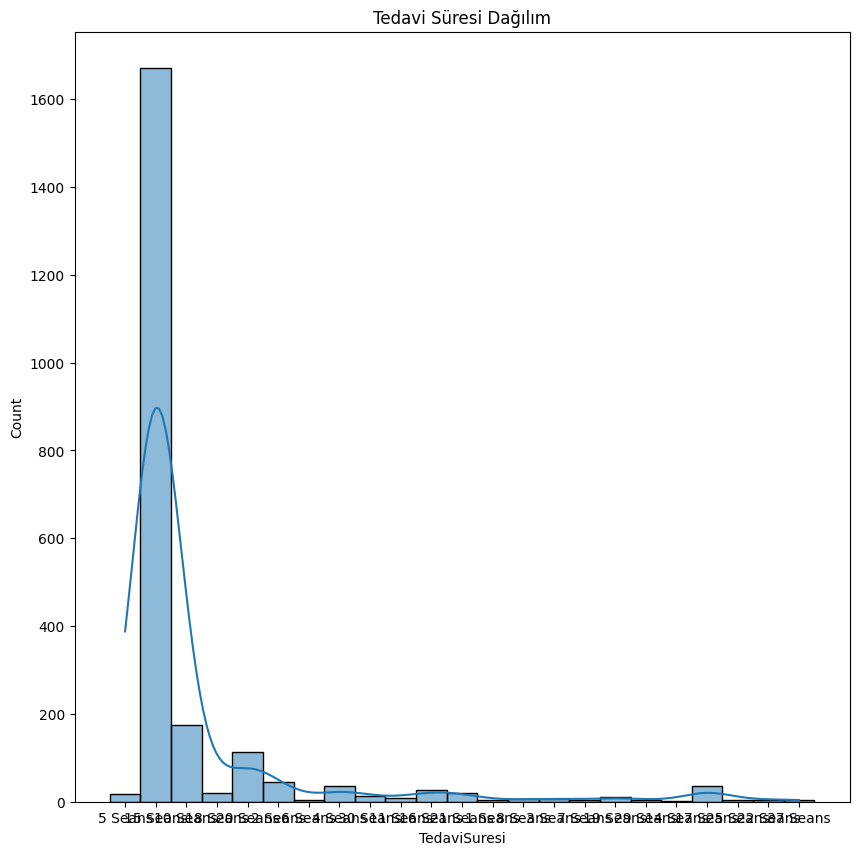

In [31]:
# Histogram grafiği ile görsellşetiriyoruz ancak seans sıraları karışık, verimli bir grafik değil.
plt.figure(figsize=(10,10))
sns.histplot(df["TedaviSuresi"], bins=100000000000, kde=True)
plt.title("Tedavi Süresi Dağılım")
plt.show()

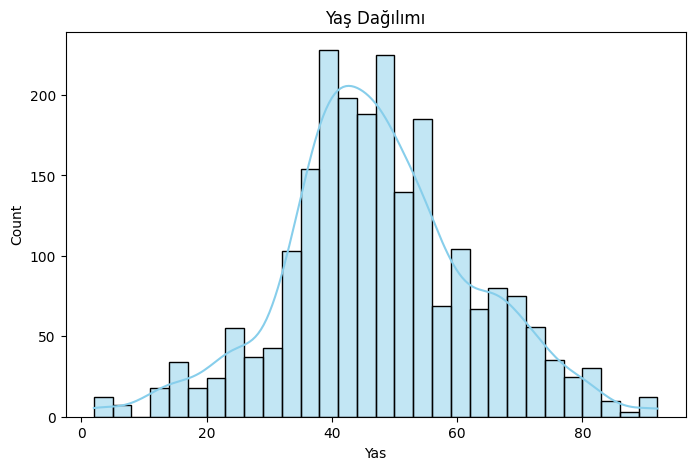

In [32]:
# Bu kez Yaşa bağlı Tedavi Süresi olan Histogram grafiğine bakıyoruz. Target sütuunmuz Tedavi Süresi olduğundan buna bağlı columsnları dikkate almalıyz.
plt.figure(figsize=(8,5))
sns.histplot(df["Yas"], bins=30, kde=True, color="skyblue")
plt.title("Yaş Dağılımı")
plt.show()

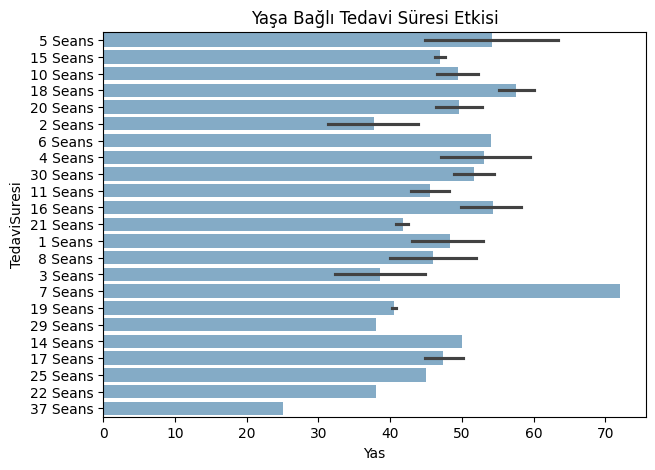

In [33]:
# Diğer örnek. Seans sıraları karışık.
plt.figure(figsize=(7, 5))
sns.barplot(x="Yas", y="TedaviSuresi", data=df, alpha=0.6)
plt.title("Yaşa Bağlı Tedavi Süresi Etkisi")
plt.show()

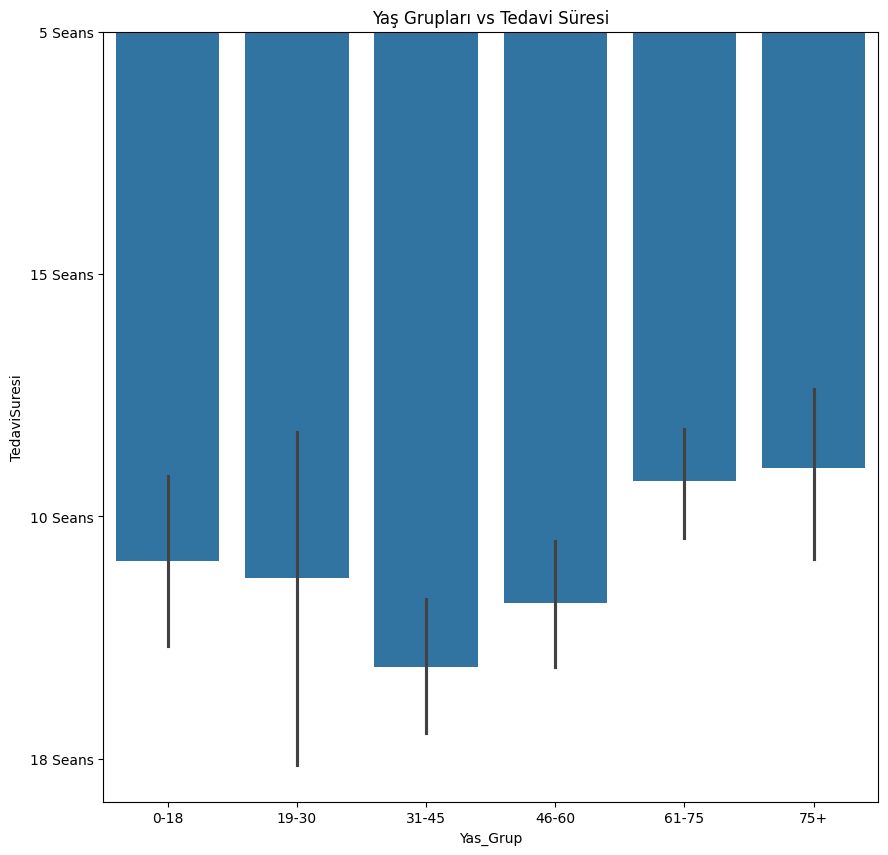

In [34]:
df["Yas_Grup"] = pd.cut(df["Yas"], bins=[0, 18, 30, 45, 60, 80, 100], labels=["0-18", "19-30", "31-45", "46-60", "61-75", "75+"])

plt.figure(figsize=(10, 10))
sns.barplot(x="Yas_Grup", y="TedaviSuresi", data=df)
plt.title("Yaş Grupları vs Tedavi Süresi")
plt.show()

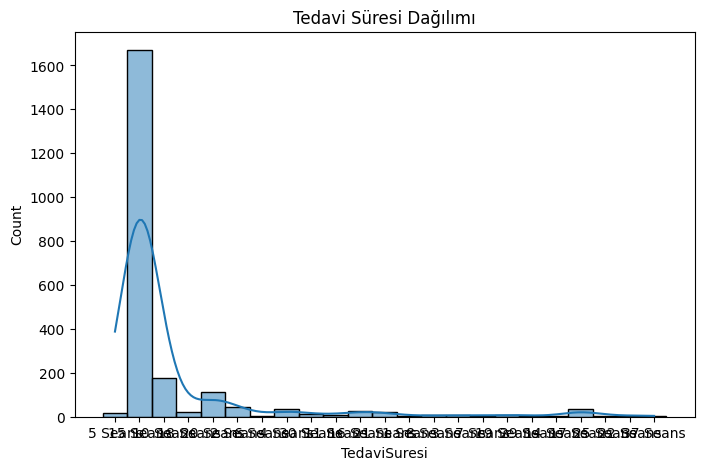

In [35]:
plt.figure(figsize=(8,5))
sns.histplot(df["TedaviSuresi"], bins=30, kde=True)
plt.title("Tedavi Süresi Dağılımı")
plt.show()


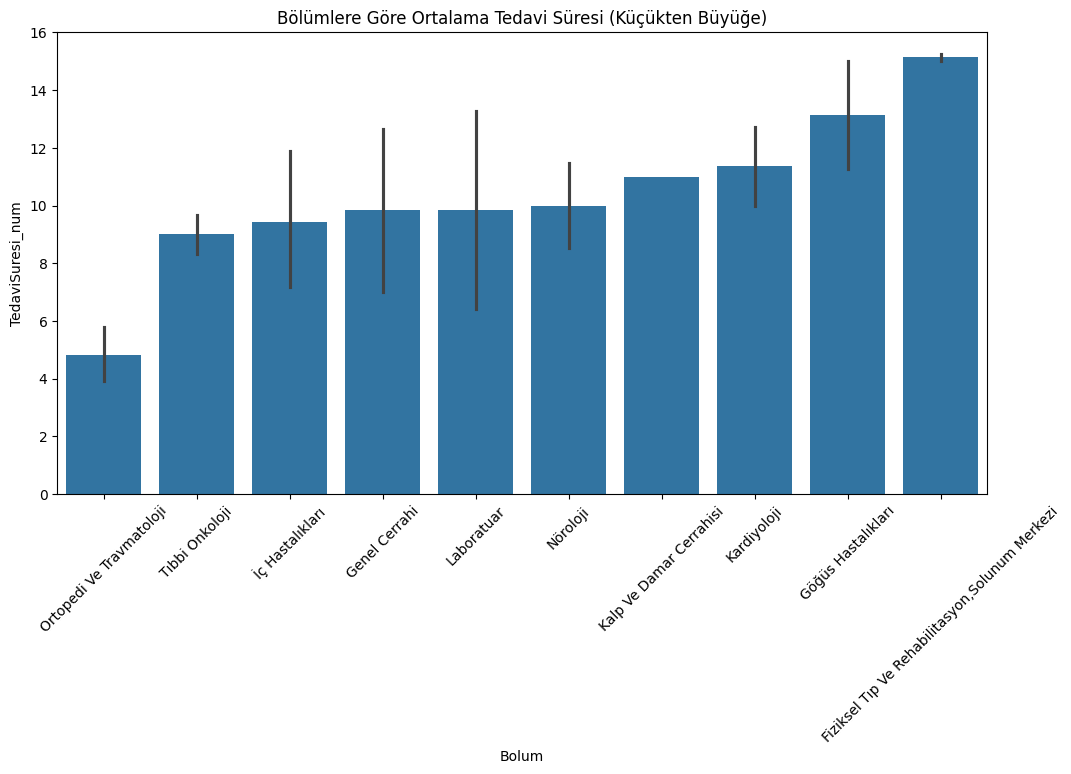

In [49]:
plt.figure(figsize=(12,6))
sns.barplot(
    x="Bolum",
    y="TedaviSuresi_num",
    data=df,
    order=df.groupby("Bolum")["TedaviSuresi_num"].mean().sort_values().index
)
plt.xticks(rotation=45)
plt.title("Bölümlere Göre Ortalama Tedavi Süresi (Küçükten Büyüğe)")
plt.show()

In [50]:
#Aykırı değerleri hesaplıyoruz

df["TedaviSuresi_num"] = df["TedaviSuresi"].str.extract(r'(\d+)').astype(float)

Q1 = df["TedaviSuresi_num"].quantile(0.25)
Q3 = df["TedaviSuresi_num"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["TedaviSuresi_num"] < lower_bound) | (df["TedaviSuresi_num"] > upper_bound)]

print(f"Aykırı değer sayısı: {outliers.shape[0]}")
print(outliers["TedaviSuresi_num"].value_counts().sort_index())


Aykırı değer sayısı: 565
TedaviSuresi_num
1.0       3
2.0      45
3.0       7
4.0      35
5.0      17
6.0       3
7.0       5
8.0       6
10.0    175
11.0      9
14.0      2
16.0     27
17.0     36
18.0     20
19.0     10
20.0    113
21.0     20
22.0      5
25.0      5
29.0      5
30.0     12
37.0      5
Name: count, dtype: int64


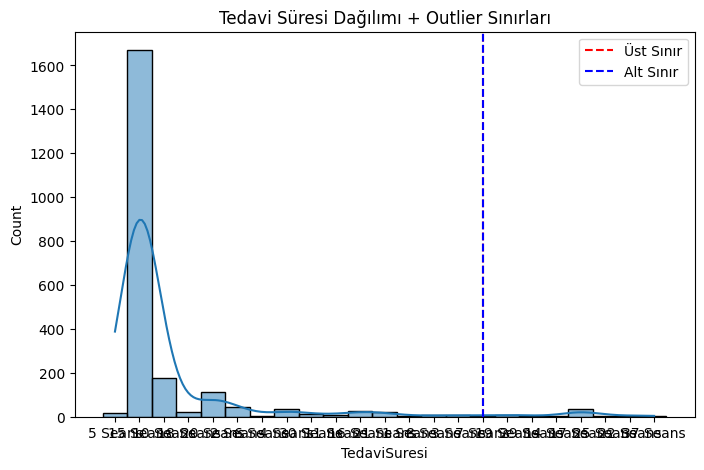

In [51]:
plt.figure(figsize=(8,5))
sns.histplot(df["TedaviSuresi"], bins=30, kde=True)
plt.axvline(upper_bound, color="red", linestyle="--", label="Üst Sınır")
plt.axvline(lower_bound, color="blue", linestyle="--", label="Alt Sınır")
plt.title("Tedavi Süresi Dağılımı + Outlier Sınırları")
plt.legend()
plt.show()


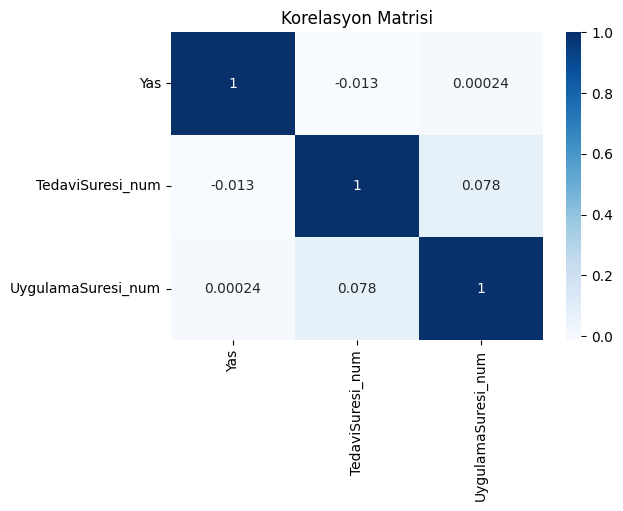

In [48]:
plt.figure(figsize=(6,4))
corr = df[["Yas", "TedaviSuresi_num", "UygulamaSuresi_num"]].corr()
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Korelasyon Matrisi")
plt.show()

In [ ]:
#PREPROCESSING PHASE

In [39]:
# Burada type dönüştürmemiz lazım
df["TedaviSuresi_num"] = df["TedaviSuresi"].str.extract(r'(\d+)').astype(float)
df["UygulamaSuresi_num"] = df["UygulamaSuresi"].str.extract(r'(\d+)').astype(float)

In [40]:
# Gereksiz sütunları siliyoruz
X = df.drop(columns=["TedaviSuresi", "TedaviSuresi_num", "HastaNo"])
y = df["TedaviSuresi_num"]

In [41]:
# Featuring yapıyoruz
numeric_features = ["Yas", "UygulamaSuresi_num"]
categorical_features = ["Cinsiyet", "KanGrubu", "Uyruk", "Bolum", "TedaviAdi"]

In [42]:
# Pipeline
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                                      ("scaler", StandardScaler())])


categorical_transformer = Pipeline(steps=[(
    "imputer", SimpleImputer(strategy="most_frequent")),
                                          ("onehot", OneHotEncoder(handle_unknown = "ignore"))])

In [43]:
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features),
                  ("cat", categorical_transformer, categorical_features)]
)

In [44]:
# Model istenmedi ancak veri nasıl kaliteli mi ölçmek için yapalım.
model = Pipeline(steps=[("preprocessor", preprocessor),
                        ("regressor", RandomForestRegressor(n_estimators=200, random_state=42))])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Yas',
                                                   'UygulamaSuresi_num']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Cinsiyet', 'KanGrubu',
                                                   'Uyruk', 'Bolum',
                                                   'TedaviAdi'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=200, random_state=42))])

In [47]:
scores = cross_val_score(model, X, y, cv=5, scoring="r2")
print("Scores:", scores)
print("Mean:", scores.mean())

Scores: [ 0.47483281  0.3553876  -0.07986041 -0.15084084  0.12052018]
Mean: 0.1440078667013069


In [ ]:
#Skor düşük normal değeri 0.3-0.6 ayrıca negatif değerler var bu demektir verimiz kalitesiz. Çözüm olarak featuring ve dönüşümleri yeniden yapabiliriz,  ve aykırı değerlere bakmamız gerekir.
# Ancak bu kısım case'e dahil olmadığı için burada bırakıyoruz.